In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import optax

from dm_pix import ssim
from dm_pix import psnr
from flax.training import train_state

from dln.data import get_Low_light_training_set
from dln.jax_dln import DLN
from dln.jax_data_loader import jnp_data_loader
from dln.jax_tv import total_variation

In [4]:
@jax.jit
def apply_model(state, ll, nl):

    def loss_fn(params):
        nl_pred = state.apply_fn({"params": params}, ll)
        ssim_loss = 1 - ssim(nl, nl_pred)
        tv_loss = total_variation(nl_pred)
        loss = ssim_loss + 0.001 * tv_loss
        return jnp.mean(loss), nl_pred

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, nl_pred), grads = grad_fn(state.params)
    res_psnr = psnr(nl, nl_pred)
    return grads, loss, jnp.mean(res_psnr)

def train_step(state, batch):
    def loss_fn(params):
        nl_pred = state.apply_fn({"params": params}, batch["ll"])
        ssim_loss = 1 - ssim(batch["nl"], nl_pred)
        tv_loss = total_variation(nl_pred)
        loss = ssim_loss + 0.001 * tv_loss
        return jnp.mean(loss), nl_pred
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    aux, grads = grad_fn(state.params)
    grads = jax.lax.pmean(grads, axis_name="batch")
    # loss, 

def train_epoch(state, data_loader):
    epoch_loss = []
    epoch_psnr = []
    for ll, nl in data_loader:
        grads, loss, res_psnr = apply_model(state, ll, nl)
        new_state = state.apply_gradients(grads=grads)
        epoch_loss.append(loss)
        epoch_psnr.append(res_psnr)
    return new_state, np.mean(epoch_loss), np.mean(epoch_psnr)


def create_train_state(rng, model, lr):
    state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=model.init(rng, jnp.ones((1, 256, 256, 3)))["params"],
        tx=optax.adam(learning_rate=lr),
    )
    return state

In [5]:
rng = jax.random.key(0)
rng, init_rng = jax.random.split(rng)
model = DLN(64)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [9]:
variables = model.init(rng, jnp.ones((1, 256, 256, 3)))

In [11]:
variables

{'params': {'ConvBlock_0': {'Conv_0': {'kernel': Array([[[ 0.21895997, -0.01380041, -0.50533795, ..., -0.04732133,
              0.08211236,  0.11598042],
            [-0.10135698,  0.38291898,  0.04785426, ...,  0.150515  ,
              0.11655758,  0.1052337 ],
            [-0.08947388, -0.453631  ,  0.27914622, ..., -0.2081166 ,
             -0.20011288,  0.0972065 ],
            [-0.03397783,  0.1640419 , -0.02843255, ..., -0.00702858,
              0.3795642 , -0.03058464]],
    
           [[-0.23061085, -0.4148505 ,  0.61886394, ..., -0.37857002,
              0.07403833,  0.09648664],
            [-0.2190719 , -0.23791637, -0.05196919, ...,  0.25813007,
             -0.14530355, -0.16455297],
            [ 0.08995105, -0.56639284,  0.09348922, ...,  0.07898468,
             -0.47379062,  0.4646419 ],
            [ 0.24609546,  0.09727007,  0.54750836, ...,  0.5327702 ,
              0.13507392,  0.31757122]],
    
           [[ 0.38876823,  0.17944951, -0.13191666, ..., -0.377

In [ ]:
p_train_step = jax.pmap(functools.partial(train_step), axis_name='batch')

In [4]:
rng = jax.random.key(0)
rng, init_rng = jax.random.split(rng)
model = DLN(64)
state = create_train_state(init_rng, model, 1e-3)
train_set = get_Low_light_training_set(
    upscale_factor=1, patch_size=128, data_augmentation=True
)
data_loader = jnp_data_loader(train_set, batch_size=8)

2024-05-28 22:51:32.216387: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Before training:
PSNR: 5.0458593
SSIM: 0.2608439


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7477787..0.63384193].


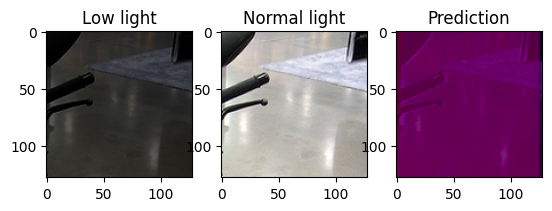

In [5]:
# Show prediction before training
first_ll, first_nl = next(data_loader)
first_nl_pred = state.apply_fn({"params": state.params}, first_ll)
print("Before training:")
print("PSNR:", np.mean(psnr(first_nl, first_nl_pred)))
print("SSIM:", np.mean(ssim(first_nl, first_nl_pred)))

# Plot the first_ll and first_nl
import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
plt.imshow(first_ll[0])
plt.title("Low light")
plt.subplot(1, 3, 2)
plt.imshow(first_nl[0])
plt.title("Normal light")
plt.subplot(1, 3, 3)
plt.imshow(first_nl_pred[0])
plt.title("Prediction")
plt.show()

In [6]:
for epoch in range(10):
    state, loss, res_psnr = train_epoch(state, data_loader)
    print(f"Epoch: {epoch}, Loss: {loss}, PSNR: {res_psnr}")

2024-05-28 22:51:51.317557: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 258.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-28 22:51:51.865698: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 130.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-28 22:51:51.924105: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-28 22:51:52.427376: W external/tsl/tsl/framework/bfc_allocator.cc:291] A

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14917438..1.1192968].


Before training:
PSNR: 17.388882
SSIM: 0.77577704


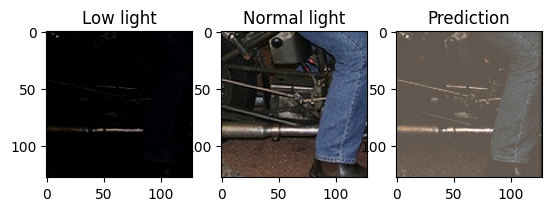

In [ ]:
#After 10 epochs
trained_pred = state.apply_fn({"params": state.params}, first_ll)
print("Before training:")
print("PSNR:", np.mean(psnr(first_nl, trained_pred)))
print("SSIM:", np.mean(ssim(first_nl, trained_pred)))

# Plot the first_ll and first_nl
import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
plt.imshow(first_ll[0])
plt.title("Low light")
plt.subplot(1, 3, 2)
plt.imshow(first_nl[0])
plt.title("Normal light")
plt.subplot(1, 3, 3)
plt.imshow(trained_pred[0])
plt.title("Prediction")
plt.show()